# Requirements

* conda create -c 

In [119]:
import numpy as np
import pandas as pd
import time
from sklearn import linear_model, datasets
from sklearn import metrics
from sklearn import preprocessing
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly_express as px

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

start = dt.date(2022, 1, 1)
end = dt.datetime.today()
plt.style.use('fivethirtyeight')
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option('display.max_colwidth', None)

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score,mean_squared_error

#import graphviz
#import pydotplus
#from sklearn.externals.six import StringIO  
from six import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image  

In [121]:
# Adapted from https://gist.github.com/doraneko94/e24643136cfb8baf03ef8a314ab9615c
from sklearn.metrics import roc_auc_score
from math import sqrt
def roc_auc_ci(y_true, y_score, positive=1):
    '''
    # y_true = TRUE data
    # y_pred = predicted data at the model
    '''
    auc = roc_auc_score(y_true, y_score)
    n1 = sum(y_true == positive)
    n2 = sum(y_true != positive)
    q1 = auc / (2 - auc)
    q2 = 2*auc**2 / (1 + auc)
    se_auc = sqrt((auc*(1 - auc) + (n1 - 1)*(q1 - auc**2) + (n2 - 1)*(q2 - auc**2)) / (n1*n2))
    lower = auc - 1.96*se_auc
    upper = auc + 1.96*se_auc
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, upper)

In [122]:
df_btc = pd.read_csv('./data/btc1h_usdt.csv', index_col=0)
df_btc_day = pd.read_csv('./data/btc1d_usdt.csv', index_col=0)

In [125]:
df_btc['open_time'] = pd.to_datetime(df_btc['open_time'])
df_btc['close_time'] = pd.to_datetime(df_btc['close_time'])

df_btc_day['open_time'] = pd.to_datetime(df_btc_day['open_time'])
df_btc_day['close_time'] = pd.to_datetime(df_btc_day['close_time'])

In [126]:
df_btc.dtypes

open_time                    datetime64[ns]
open                                float64
high                                float64
low                                 float64
close                               float64
volume                              float64
close_time                   datetime64[ns]
quote_vol                           float64
trades                              float64
taker_buy_base                      float64
taker_buy_quote                     float64
ignore                                int64
symbol                               object
volume_adi                          float64
volume_obv                          float64
volume_cmf                          float64
volume_fi                           float64
volume_em                           float64
volume_sma_em                       float64
volume_vpt                          float64
volume_vwap                         float64
volume_mfi                          float64
volume_nvi                      

In [127]:
df_btc['nextclose'] = df_btc['close'].shift(-1)
df_btc_day['nextclose'] = df_btc_day['close'].shift(-1)

In [128]:
df_btc['dif_nextclose'] = df_btc['nextclose'] - df_btc['close']
df_btc_day['dif_nextclose'] = df_btc_day['nextclose'] - df_btc_day['close']

In [129]:
df_btc['var_nextclose'] = 0.00
df_btc.var_nextclose = ((df_btc['nextclose']-df_btc['close'])/df_btc['close'])*100

df_btc_day['var_nextclose'] = 0.00
df_btc_day.var_nextclose = ((df_btc_day['nextclose']-df_btc_day['close'])/df_btc_day['close'])*100

In [130]:
df_btc.tail()

open_time      open      high       low     close      volume  \
59209 2024-05-24 17:00:00  68394.32  68855.92  68394.32  68848.01  1656.63083   
59210 2024-05-24 18:00:00  68919.02  69220.00  68840.00  68971.99  1709.56717   
59211 2024-05-24 19:00:00  68970.43  69061.85  68738.33  69053.99   737.61793   
59212 2024-05-24 20:00:00  69115.98  69214.00  68901.30  68947.99   671.53851   
59213 2024-05-24 21:00:00  68836.96  68995.77  68800.00  68869.99   394.26385   

                   close_time     quote_vol   trades  taker_buy_base  \
59209 2024-05-24 17:59:59.999  1.136605e+08  58338.0       928.08733   
59210 2024-05-24 18:59:59.999  1.180154e+08  55386.0       935.95629   
59211 2024-05-24 19:59:59.999  5.082461e+07  31132.0       358.05558   
59212 2024-05-24 20:59:59.999  4.635166e+07  29935.0       273.69576   
59213 2024-05-24 21:59:59.999  2.715666e+07  23262.0       193.80699   

       taker_buy_quote  ignore   symbol    volume_adi   volume_obv  \
59209     6.367234e+07       0  BTCUSDT  24790.403629  34995.81663   
59210     6.461214e+07       0  BTCUSDT  24453.807363  36919.60492   
59211     2.467124e+07       0  BTCUSDT  25133.268502  37683.62930   
59212     1.889121e+07       0  BTCUSDT  24370.638361  37135.86061   
59213     1.334931e+07       0  BTCUSDT  24029.042039  37501.42248   

       volume_cmf      volume_fi     volume_em  volume_sma_em  volume_vpt  \
59209    0.188478  292262.457939  1.186997e+10   1.418738e+09   12.633929   
59210    0.181518  291615.017399  8.161733e+09   2.370900e+09   15.666265   
59211    0.175286  258600.448882 -5.697866e+09   3.199114e+09    2.188595   
59212    0.138995  213346.415708  2.956161e+09   4.154777e+09    0.185598   
59213    0.129565  174618.186145 -6.335674e+09   3.954986e+09   -2.637679   

        volume_vwap  volume_mfi   volume_nvi  volatility_bbm  volatility_bbh  \
59209  67597.847065   49.167737  1020.941768      67672.2860    68628.845252   
59210  67721.726823   56.227620  1021.726447      67740.1125    68866.528709   
59211  67793.292720   58.103632  1022.941166      67794.2515    69055.615234   
59212  67925.949436   66.696893  1021.370920      67852.1505    69221.526214   
59213  68011.641556   70.274755  1020.215455      67902.9980    69325.467102   

       volatility_bbl  volatility_bbw  volatility_bbp  volatility_bbhi  \
59209    66715.726748        2.827034        1.114559              1.0   
59210    66613.696291        3.325699        1.046813              1.0   
59211    66532.887766        3.721152        0.999356              0.0   
59212    66482.774786        4.036352        0.900124              0.0   
59213    66480.528898        4.189709        0.839899              0.0   

       volatility_bbli  volatility_kcc  volatility_kch  volatility_kcl  \
59209              0.0    67653.026667    68148.383667    67157.669667   
59210              0.0    67858.336000    68336.360000    67380.312000   
59211              0.0    68024.618333    68494.010333    67555.226333   
59212              0.0    68195.455000    68693.666000    67697.244000   
59213              0.0    68341.786000    68846.477000    67837.095000   

       volatility_kcw  volatility_kcp  volatility_kchi  volatility_kcli  \
59209        1.464405        1.706184              1.0              0.0   
59210        1.408888        1.664852              1.0              0.0   
59211        1.380065        1.596495              1.0              0.0   
59212        1.461127        1.255237              1.0              0.0   
59213        1.476962        1.023294              1.0              0.0   

       volatility_dcl  volatility_dch  volatility_dcm  volatility_dcw  \
59209        66600.12        68855.92        67728.02        3.333418   
59210        66600.12        69220.00        67910.06        3.867546   
59211        66600.12        69220.00        67910.06        3.864457   
59212        66600.12        69250.00        67925.06        3.905374   
59213        66600.12    

In [131]:
df_btc.dif_nextclose.describe()

count    59213.000000
mean         1.090321
std        212.353819
min      -3789.750000
25%        -40.670000
50%          1.060000
75%         44.510000
max       3973.890000
Name: dif_nextclose, dtype: float64

In [132]:
df_btc_day.dif_nextclose.describe()

count    2458.000000
mean       23.888979
std      1016.307938
min     -7038.700000
25%      -223.437500
50%         9.170000
75%       266.855000
max      7579.180000
Name: dif_nextclose, dtype: float64

In [133]:
#px.line(df_btc.tail(100),x='open_time',y='var_nextclose',width=1500,height=800,title="BTC var next close",color_discrete_sequence=['green'])

In [134]:
#import pygwalker as pyg
#walker = pyg.walk(df_btc.tail(1000))

In [135]:
df_btc['price_increase_quartil'] = 0

df_btc_day['price_increase_quartil'] = 0

In [136]:
df_btc['price_increase_quartil'] = pd.qcut(df_btc['dif_nextclose'], q=4, labels=False) + 1

df_btc_day['price_increase_quartil'] = pd.qcut(df_btc_day['dif_nextclose'], q=4, labels=False) + 1

In [137]:
df_btc['price_increase_quartil'].value_counts()

price_increase_quartil
1.0    14804
3.0    14803
4.0    14803
2.0    14803
Name: count, dtype: int64

In [138]:
df_btc_day['price_increase_quartil'].value_counts()

price_increase_quartil
1.0    615
4.0    615
2.0    614
3.0    614
Name: count, dtype: int64

In [139]:
df_btc[df_btc['price_increase_quartil']==4].tail()

open_time      open      high       low     close      volume  \
59206 2024-05-24 14:00:00  67077.12  68031.62  67000.00  67870.31  2173.06931   
59207 2024-05-24 15:00:00  67869.49  68420.00  67869.48  68221.78  1924.50366   
59208 2024-05-24 16:00:00  68326.46  68473.85  67924.39  68375.57  1623.34907   
59209 2024-05-24 17:00:00  68394.32  68855.92  68394.32  68848.01  1656.63083   
59210 2024-05-24 18:00:00  68919.02  69220.00  68840.00  68971.99  1709.56717   

                   close_time     quote_vol   trades  taker_buy_base  \
59206 2024-05-24 14:59:59.999  1.470290e+08  83366.0      1143.18912   
59207 2024-05-24 15:59:59.999  1.313111e+08  75579.0       991.16558   
59208 2024-05-24 16:59:59.999  1.107183e+08  63541.0       806.94527   
59209 2024-05-24 17:59:59.999  1.136605e+08  58338.0       928.08733   
59210 2024-05-24 18:59:59.999  1.180154e+08  55386.0       935.95629   

       taker_buy_quote  ignore   symbol    volume_adi   volume_obv  \
59206     7.737234e+07       0  BTCUSDT  20654.217648  29619.53380   
59207     6.762507e+07       0  BTCUSDT  21210.263170  31574.53445   
59208     5.504034e+07       0  BTCUSDT  23056.451076  33306.46874   
59209     6.367234e+07       0  BTCUSDT  24790.403629  34995.81663   
59210     6.461214e+07       0  BTCUSDT  24453.807363  36919.60492   

       volume_cmf      volume_fi     volume_em  volume_sma_em  volume_vpt  \
59206    0.190767  113708.321638  1.193114e+10  -5.584165e+08   12.085007   
59207    0.237995  197059.870807  1.799106e+10   8.547848e+08   36.019807   
59208    0.190404  211041.697663  1.840617e+09   7.281515e+08   14.856021   
59209    0.188478  292262.457939  1.186997e+10   1.418738e+09   12.633929   
59210    0.181518  291615.017399  8.161733e+09   2.370900e+09   15.666265   

        volume_vwap  volume_mfi   volume_nvi  volatility_bbm  volatility_bbh  \
59206  67388.059257   36.479273  1013.119572      67543.6695    68215.344158   
59207  67459.141664   44.521466  1018.366065      67594.7180    68308.130236   
59208  67515.933088   47.069451  1020.661732      67628.5860    68432.386738   
59209  67597.847065   49.167737  1020.941768      67672.2860    68628.845252   
59210  67721.726823   56.227620  1021.726447      67740.1125    68866.528709   

       volatility_bbl  volatility_bbw  volatility_bbp  volatility_bbhi  \
59206    66871.994842        1.988860        0.743154              0.0   
59207    66881.305764        2.110852        0.939481              0.0   
59208    66824.785262        2.377103        0.964657              0.0   
59209    66715.726748        2.827034        1.114559              1.0   
59210    66613.696291        3.325699        1.046813              1.0   

       volatility_bbli  volatility_kcc  volatility_kch  volatility_kcl  \
59206              0.0    67292.553333    67821.546333    66763.560333   
59207              0.0    67373.260667    67894.581667    66851.939667   
59208              0.0    67492.316333    67989.844333    66994.788333   
59209              0.0    67653.026667    68148.383667    67157.669667   
59210              0.0    67858.336000    68336.360000    67380.312000   

       volatility_kcw  volatility_kcp  volatility_kchi  volatility_kcli  \
59206        1.572219        1.046091              1.0              0.0   
59207        1.547561        1.313817              1.0              0.0   
59208        1.474325        1.387642              1.0              0.0   
59209        1.464405        1.706184              1.0              0.0   
59210        1.408888        1.664852              1.0              0.0   

       volatility_dcl  volatility_dch  volatility_dcm  volatility_dcw  \
59206        66312.16        68365.81       67338.985        3.040477   
59207        66312.16        68420.00       67366.080        3.118350   
59208        66600.12        68473.85       67536.985        2.770618   
59209        66600.12        68855.92       67728.020        3.333418   
59210        66600.12    

In [140]:
#df_btc[df_btc.isnull().any(axis=1)]

In [141]:
features = ["trades", "volume", "momentum_rsi", "momentum_stoch_rsi", "morningstar", "hammer", "piercing", "engulfing", "3soldiers", "slope","slope_obv"]
df_btc.dropna(inplace=True, axis=0, subset=features)
df_btc_day.dropna(inplace=True, axis=0, subset=features)


In [142]:
df_btc.shape

(59188, 115)

In [143]:
df_btc_day.shape

(2418, 112)

In [144]:
# check null values
df_btc.isnull().any()

open_time                    False
open                         False
high                         False
low                          False
close                        False
volume                       False
close_time                   False
quote_vol                    False
trades                       False
taker_buy_base               False
taker_buy_quote              False
ignore                       False
symbol                       False
volume_adi                   False
volume_obv                   False
volume_cmf                   False
volume_fi                    False
volume_em                    False
volume_sma_em                False
volume_vpt                   False
volume_vwap                  False
volume_mfi                   False
volume_nvi                   False
volatility_bbm               False
volatility_bbh               False
volatility_bbl               False
volatility_bbw               False
volatility_bbp               False
volatility_bbhi     

In [145]:
# where are the null values
df_btc[pd.isnull(df_btc.var_nextclose)]

open_time      open      high      low     close     volume  \
59213 2024-05-24 21:00:00  68836.96  68995.77  68800.0  68869.99  394.26385   

                   close_time     quote_vol   trades  taker_buy_base  \
59213 2024-05-24 21:59:59.999  2.715666e+07  23262.0       193.80699   

       taker_buy_quote  ignore   symbol    volume_adi   volume_obv  \
59213     1.334931e+07       0  BTCUSDT  24029.042039  37501.42248   

       volume_cmf      volume_fi     volume_em  volume_sma_em  volume_vpt  \
59213    0.129565  174618.186145 -6.335674e+09   3.954986e+09   -2.637679   

        volume_vwap  volume_mfi   volume_nvi  volatility_bbm  volatility_bbh  \
59213  68011.641556   70.274755  1020.215455       67902.998    69325.467102   

       volatility_bbl  volatility_bbw  volatility_bbp  volatility_bbhi  \
59213    66480.528898        4.189709        0.839899              0.0   

       volatility_bbli  volatility_kcc  volatility_kch  volatility_kcl  \
59213              0.0       68341.786       68846.477       67837.095   

       volatility_kcw  volatility_kcp  volatility_kchi  volatility_kcli  \
59213        1.476962        1.023294              1.0              0.0   

       volatility_dcl  volatility_dch  volatility_dcm  volatility_dcw  \
59213        66600.12         69250.0        67925.06        3.902449   

       volatility_dcp  volatility_atr  volatility_ui  trend_macd  \
59213        0.856594       477.16152       0.683797  194.293887   

       trend_macd_signal  trend_macd_diff  trend_sma_fast  trend_sma_slow  \
59213         -23.728958       218.022845      68214.4325    67888.682692   

       trend_ema_fast  trend_ema_slow  trend_vortex_ind_pos  \
59213    68412.398395    68218.104508              1.303656   

       trend_vortex_ind_neg  trend_vortex_ind_diff  trend_trix  \
59213              0.740626                0.56303   -0.010596   

       trend_mass_index  trend_dpo  trend_kst  trend_kst_sig  trend_kst_diff  \
59213         23.735652   -549.568  -0.628295     -11.192531       10.564236   

       trend_ichimoku_conv  trend_ichimoku_base  trend_ichimoku_a  \
59213            68085.985             67781.08        67933.5325   

       trend_ichimoku_b  trend_stc  trend_adx  trend_adx_pos  trend_adx_neg  \
59213          68204.14  99.901181  30.209335      21.458651      18.653761   

        trend_cci  trend_visual_ichimoku_a  trend_visual_ichimoku_b  \
59213  112.322478                 68430.41                 68715.35   

       trend_aroon_up  trend_aroon_down  trend_aroon_ind  trend_psar_up  \
59213            92.0              40.0             52.0   67853.291358   

       trend_psar_down  trend_psar_up_indicator  trend_psar_down_indicator  \
59213              NaN                      0.0                        0.0   

       momentum_rsi  momentum_stoch_rsi  momentum_stoch_rsi_k  \
59213      60.33577            0.835288               0.88685   

       momentum_stoch_rsi_d  momentum_tsi  momentum_uo  momentum_stoch  \
59213              0.942868     10.430412    64.940042       85.659351   

       momentum_stoch_signal  momentum_wr  momentum_ao  momentum_roc  \
59213              88.338214   -14.340649  1044.476941      2.218515   

       momentum_ppo  momentum_ppo_signal  momentum_ppo_hist  momentum_kama  \
59213    -11.136159            -4.330191          -6.805968   68586.255431   

       others_dr  others_dlr  others_cr  morningstar  hammer  piercing  \
59213   0.047983    0.047971   9.639349            0       0         0   

       3soldiers  engulfing  momentum_pvo  momentum_pvo_signal  \
59213          0          0           NaN                  NaN   

       momentum_pvo_hist       sma200      sma50        ema200         ema50  \
59213                NaN  67969.30795  68419.956  67665.324186  68402.988207   

          slope    slope_obv  slope_rsi  nextclose  dif_nextclose  \
59213  9.826992  1191.316873   2.557395        NaN            NaN   

       var_nextclose  price_incre

In [146]:
# where are the null values
df_btc_day[pd.isnull(df_btc_day.var_nextclose)]

open_time     open     high       low     close      volume  \
2458 2024-05-10  63074.0  63380.0  62660.42  63004.19  8886.46041   

                  close_time     quote_vol  trades  taker_buy_base  \
2458 2024-05-10 23:59:59.999  5.596623e+08  384230      4766.78558   

      taker_buy_quote  ignore   symbol    volume_adi    volume_obv  \
2458     3.002595e+08       0  BTCUSDT  1.158044e+06  1.301528e+06   

      volume_cmf     volume_fi     volume_em  volume_sma_em  volume_vpt  \
2458    0.021546 -2.314524e+06  8.022140e+09   5.198119e+08  932.629311   

       volume_vwap  volume_mfi   volume_nvi  volatility_bbm  volatility_bbh  \
2458  61522.649781   31.552262  1088.530871       63140.557    67217.830866   

      volatility_bbl  volatility_bbw  volatility_bbp  volatility_bbhi  \
2458    59063.283134       12.914913        0.483277              0.0   

      volatility_bbli  volatility_kcc  volatility_kch  volatility_kcl  \
2458              0.0    62015.867333    64611.736333    59419.998333   

      volatility_kcw  volatility_kcp  volatility_kchi  volatility_kcli  \
2458        8.371628        0.690365              0.0              0.0   

      volatility_dcl  volatility_dch  volatility_dcm  volatility_dcw  \
2458        56552.82        67232.35       61892.585       16.913899   

      volatility_dcp  volatility_atr  volatility_ui  trend_macd  \
2458        0.604087     2606.019433       6.507567 -786.870057   

      trend_macd_signal  trend_macd_diff  trend_sma_fast  trend_sma_slow  \
2458        -970.393247        183.52319    62124.844167    63212.714231   

      trend_ema_fast  trend_ema_slow  trend_vortex_ind_pos  \
2458    62711.438925    63498.308982              0.982822   

      trend_vortex_ind_neg  trend_vortex_ind_diff  trend_trix  \
2458               1.03883              -0.056008   -0.243549   

      trend_mass_index  trend_dpo  trend_kst  trend_kst_sig  trend_kst_diff  \
2458         23.732716    725.443 -61.231248     -64.498991        3.267743   

      trend_ichimoku_conv  trend_ichimoku_base  trend_ichimoku_a  \
2458             61205.92            61892.585        61549.2525   

      trend_ichimoku_b  trend_stc  trend_adx  trend_adx_pos  trend_adx_neg  \
2458         64675.405  15.194944    22.6349      15.884307      21.391061   

      trend_cci  trend_visual_ichimoku_a  trend_visual_ichimoku_b  \
2458  -4.828595                 66729.28                  62149.0   

      trend_aroon_up  trend_aroon_down  trend_aroon_ind  trend_psar_up  \
2458            28.0              64.0            -36.0   57247.406046   

      trend_psar_down  trend_psar_up_indicator  trend_psar_down_indicator  \
2458              NaN                      0.0                        0.0   

      momentum_rsi  momentum_stoch_rsi  momentum_stoch_rsi_k  \
2458     48.353703            0.896612              0.790414   

      momentum_stoch_rsi_d  momentum_tsi  momentum_uo  momentum_stoch  \
2458               0.74529     -8.414589    46.889798       72.105066   

      momentum_stoch_signal  momentum_wr  momentum_ao  momentum_roc  \
2458              65.617584   -27.894934 -1457.437588     -0.181294   

      momentum_ppo  momentum_ppo_signal  momentum_ppo_hist  momentum_kama  \
2458    -14.570753            -8.283305          -6.287448   63097.727284   

      others_dr  others_dlr   others_cr  morningstar  hammer  piercing  \
2458  -0.110695   -0.110757  125.570108            0       0         0   

      3soldiers  engulfing      sma200       sma50        ema200  \
2458          0          0  50809.2126  65659.6514  52858.071651   

             ema50      slope     slope_obv  slope_rsi  nextclose  \
2458  63649.430308 -44.589104  32656.108186   1.133838        NaN   

      dif_nextclose  var_nextclose  price_increase_quartil  
2458            NaN            NaN                     NaN

In [147]:
# drop null values 
df_btc.dropna(axis=0, subset=['nextclose','var_nextclose','price_increase_quartil'], inplace=True)

In [148]:
# drop null values 
df_btc_day.dropna(axis=0, subset=['nextclose','var_nextclose','price_increase_quartil'], inplace=True)

# Descriptives

## Prediction 4 quartils

In [149]:
# USE THE EXAMPLE OF DROPOUT TO CREATE THE DECISION TREE

In [150]:
# Assuming you have your data in a DataFrame df_btc 
features = ["trades", "volume", "momentum_rsi", "momentum_stoch_rsi", "morningstar", "hammer", "piercing", "engulfing", "3soldiers", "slope","slope_obv","slope_rsi"]
features = ["trades", "volume", "slope","slope_obv","slope_rsi"]
target = 'price_increase_quartil'

In [151]:
features + [target]

['trades',
 'volume',
 'slope',
 'slope_obv',
 'slope_rsi',
 'price_increase_quartil']

In [152]:
df_btc.columns

Index(['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_vol', 'trades', 'taker_buy_base',
       ...
       'sma50', 'ema200', 'ema50', 'slope', 'slope_obv', 'slope_rsi',
       'nextclose', 'dif_nextclose', 'var_nextclose',
       'price_increase_quartil'],
      dtype='object', length=115)

In [153]:
df_btc[features+[target]].tail()

trades      volume      slope    slope_obv  slope_rsi  \
59208  63541.0  1623.34907 -33.136574   323.238137   2.170460   
59209  58338.0  1656.63083 -25.468504   473.136659   2.661746   
59210  55386.0  1709.56717 -16.857649   732.045138   2.942618   
59211  31132.0   737.61793  -7.321756   998.544706   3.264008   
59212  29935.0   671.53851   1.850016  1108.364177   3.065253   

       price_increase_quartil  
59208                     4.0  
59209                     4.0  
59210                     4.0  
59211                     1.0  
59212                     1.0

In [154]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X = df_btc[features]
y = df_btc[target]

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
# 80% of data for training, 20% for testing
# create decision tree regressor object
tree_model = DecisionTreeClassifier(max_depth=5)  # Customize max_depth if needed
tree_model.fit(X_train, y_train)

# Predictions
X_test['predictions'] = tree_model.predict(X_test)
y_pred = X_test['predictions']

In [155]:
X_test.predictions = X_test.predictions.astype('int')

In [156]:
y_test.tail()

37617    4.0
11867    3.0
36988    1.0
10628    3.0
11133    4.0
Name: price_increase_quartil, dtype: float64

In [157]:
X_test.join(y_test).tail()

trades       volume      slope    slope_obv  slope_rsi  predictions  \
37617  57062.0  1674.569090   6.140794   741.063243   1.845449            4   
11867   7362.0  1244.151849  -2.031986    28.359204   0.550376            2   
36988  94169.0  2813.962870  51.011015  1288.875079   2.354436            1   
10628   5510.0   518.162458   1.021560   112.743414  -0.252650            2   
11133  15038.0  2948.002128  -7.227600  -470.670333  -0.247672            2   

       price_increase_quartil  
37617                     4.0  
11867                     3.0  
36988                     1.0  
10628                     3.0  
11133                     4.0

In [158]:
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
#print(metrics.roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.33      0.51      0.41      2967
         2.0       0.41      0.48      0.44      2988
         3.0       0.32      0.18      0.23      2911
         4.0       0.39      0.29      0.34      2972

    accuracy                           0.37     11838
   macro avg       0.37      0.37      0.35     11838
weighted avg       0.37      0.37      0.36     11838

[[1522  360  275  810]
 [ 769 1424  527  268]
 [ 744 1371  531  265]
 [1512  279  311  870]]


In [159]:
df_btc.columns

Index(['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_vol', 'trades', 'taker_buy_base',
       ...
       'sma50', 'ema200', 'ema50', 'slope', 'slope_obv', 'slope_rsi',
       'nextclose', 'dif_nextclose', 'var_nextclose',
       'price_increase_quartil'],
      dtype='object', length=115)

In [160]:
df_btc[features+['nextclose','dif_nextclose','var_nextclose','price_increase_quartil']].describe()

trades         volume         slope      slope_obv     slope_rsi  \
count  5.918700e+04   59187.000000  59187.000000   59187.000000  59187.000000   
mean   6.090436e+04    2984.684771      1.080997       0.558350      0.000216   
std    9.075615e+04    4242.186162     27.574715    2435.024478      1.383115   
min    3.000000e+00       0.052699   -273.849811 -168701.413019     -6.820536   
25%    1.215900e+04     947.240347     -5.812017    -407.411284     -0.854300   
50%    3.049500e+04    1649.454890      0.519645       2.744902      0.012188   
75%    6.672650e+04    3199.202896      8.141238     411.622917      0.870034   
max    1.442097e+06  137207.188600    209.209939   34401.591923      6.663799   

          nextclose  dif_nextclose  var_nextclose  price_increase_quartil  
count  59187.000000   59187.000000   59187.000000            59187.000000  
mean   23081.823546       1.091296       0.008224                2.499941  
std    17887.711925     212.398702       0.839586                1.118142  
min     2919.000000   -3789.750000     -18.211473                1.000000  
25%     8155.010000     -40.685000      -0.262078                1.000000  
50%    17157.500000       1.050000       0.009162                2.000000  
75%    35960.970000      44.540000       0.280946                4.000000  
max    73522.710000    3973.890000      17.383989                4.000000

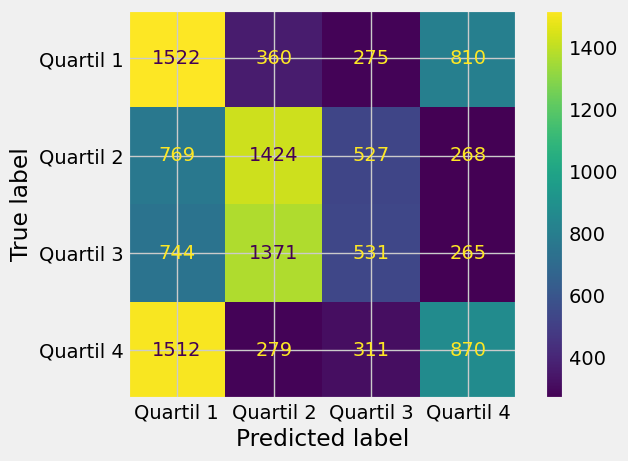

In [161]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = metrics.confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Quartil 1', 'Quartil 2', 'Quartil 3','Quartil 4']) # Replace with your class names
disp.plot()


## Prediction updown

In [162]:
df_btc['up_down'] = df_btc['dif_nextclose'].apply(lambda x: 1 if x <= 0 else 2)

In [163]:
# Assuming you have your data in a DataFrame df_btc 
#features = ["trades", "volume", "momentum_rsi", "momentum_stoch_rsi", "morningstar", "hammer", "piercing", "engulfing", "3soldiers", "slope","slope_obv","slope_rsi"]
#features = ["trades", "volume", "slope","slope_obv","slope_rsi"]
features = ["trades", "momentum_rsi", "slope","slope_obv","slope_rsi"]
target = 'up_down'

In [164]:
features + [target]

['trades', 'momentum_rsi', 'slope', 'slope_obv', 'slope_rsi', 'up_down']

In [165]:
df_btc.columns

Index(['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_vol', 'trades', 'taker_buy_base',
       ...
       'ema200', 'ema50', 'slope', 'slope_obv', 'slope_rsi', 'nextclose',
       'dif_nextclose', 'var_nextclose', 'price_increase_quartil', 'up_down'],
      dtype='object', length=116)

In [166]:
df_btc[features+[target]].tail()

trades  momentum_rsi      slope    slope_obv  slope_rsi  up_down
59208  63541.0     57.052543 -33.136574   323.238137   2.170460        2
59209  58338.0     62.292852 -25.468504   473.136659   2.661746        2
59210  55386.0     63.503325 -16.857649   732.045138   2.942618        2
59211  31132.0     64.354298  -7.321756   998.544706   3.264008        1
59212  29935.0     61.848578   1.850016  1108.364177   3.065253        1

In [167]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X = df_btc[features]
y = df_btc[target]

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
# 80% of data for training, 20% for testing
# create decision tree regressor object
tree_model = DecisionTreeClassifier(max_depth=5)  # Customize max_depth if needed
tree_model.fit(X_train, y_train)

# Predictions
X_test['predictions'] = tree_model.predict(X_test)
y_pred = X_test['predictions']

In [168]:
X_test.predictions = X_test.predictions.astype('int')

In [169]:
y_test.tail()

37617    2
11867    2
36988    1
10628    2
11133    2
Name: up_down, dtype: int64

In [170]:
y_test.value_counts()

up_down
2    5997
1    5841
Name: count, dtype: int64

In [171]:
X_test.join(y_test).tail()

trades  momentum_rsi      slope    slope_obv  slope_rsi  predictions  \
37617  57062.0     63.904678   6.140794   741.063243   1.845449            1   
11867   7362.0     47.905367  -2.031986    28.359204   0.550376            1   
36988  94169.0     55.783407  51.011015  1288.875079   2.354436            1   
10628   5510.0     53.728123   1.021560   112.743414  -0.252650            2   
11133  15038.0     37.275363  -7.227600  -470.670333  -0.247672            2   

       up_down  
37617        2  
11867        2  
36988        1  
10628        2  
11133        2

In [172]:
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
#print(metrics.roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.53      0.42      0.47      5841
           2       0.53      0.64      0.58      5997

    accuracy                           0.53     11838
   macro avg       0.53      0.53      0.52     11838
weighted avg       0.53      0.53      0.52     11838

[[2432 3409]
 [2174 3823]]


In [173]:
df_btc.columns

Index(['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_vol', 'trades', 'taker_buy_base',
       ...
       'ema200', 'ema50', 'slope', 'slope_obv', 'slope_rsi', 'nextclose',
       'dif_nextclose', 'var_nextclose', 'price_increase_quartil', 'up_down'],
      dtype='object', length=116)

In [174]:
df_btc[features+['nextclose','dif_nextclose','var_nextclose','price_increase_quartil']].describe()

trades  momentum_rsi         slope      slope_obv     slope_rsi  \
count  5.918700e+04  59187.000000  59187.000000   59187.000000  59187.000000   
mean   6.090436e+04     50.848544      1.080997       0.558350      0.000216   
std    9.075615e+04     12.260407     27.574715    2435.024478      1.383115   
min    3.000000e+00      4.365657   -273.849811 -168701.413019     -6.820536   
25%    1.215900e+04     43.090401     -5.812017    -407.411284     -0.854300   
50%    3.049500e+04     50.858016      0.519645       2.744902      0.012188   
75%    6.672650e+04     58.491740      8.141238     411.622917      0.870034   
max    1.442097e+06     96.410500    209.209939   34401.591923      6.663799   

          nextclose  dif_nextclose  var_nextclose  price_increase_quartil  
count  59187.000000   59187.000000   59187.000000            59187.000000  
mean   23081.823546       1.091296       0.008224                2.499941  
std    17887.711925     212.398702       0.839586                1.118142  
min     2919.000000   -3789.750000     -18.211473                1.000000  
25%     8155.010000     -40.685000      -0.262078                1.000000  
50%    17157.500000       1.050000       0.009162                2.000000  
75%    35960.970000      44.540000       0.280946                4.000000  
max    73522.710000    3973.890000      17.383989                4.000000

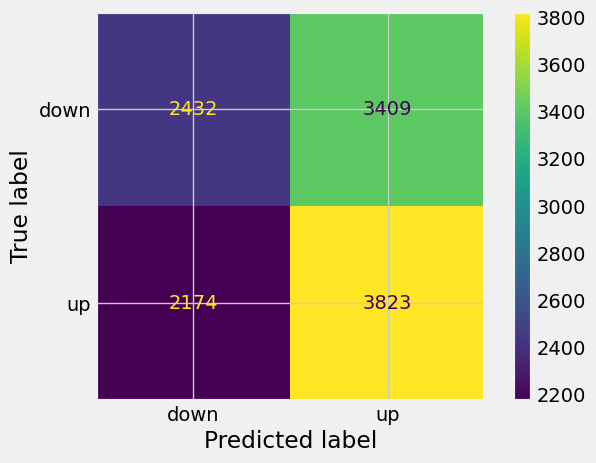

In [175]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = metrics.confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['down', 'up']) # Replace with your class names
disp.plot()


## Prediction updown slopes updown

In [176]:
df_btc['up_down'] = df_btc['dif_nextclose'].apply(lambda x: 0 if x <= 0 else 1)
df_btc['up_down_rsi'] = df_btc['slope_rsi'].apply(lambda x: 0 if x <= 0 else 1)
df_btc['up_down_obv'] = df_btc['slope_obv'].apply(lambda x: 0 if x <= 0 else 1)
df_btc['up_down_ma'] = df_btc['slope'].apply(lambda x: 0 if x <= 0 else 1)

In [177]:
features + [target]

['trades', 'momentum_rsi', 'slope', 'slope_obv', 'slope_rsi', 'up_down']

In [178]:
df_btc.columns

Index(['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_vol', 'trades', 'taker_buy_base',
       ...
       'slope_obv', 'slope_rsi', 'nextclose', 'dif_nextclose', 'var_nextclose',
       'price_increase_quartil', 'up_down', 'up_down_rsi', 'up_down_obv',
       'up_down_ma'],
      dtype='object', length=119)

In [179]:
df_btc[features+[target]].tail()

trades  momentum_rsi      slope    slope_obv  slope_rsi  up_down
59208  63541.0     57.052543 -33.136574   323.238137   2.170460        1
59209  58338.0     62.292852 -25.468504   473.136659   2.661746        1
59210  55386.0     63.503325 -16.857649   732.045138   2.942618        1
59211  31132.0     64.354298  -7.321756   998.544706   3.264008        0
59212  29935.0     61.848578   1.850016  1108.364177   3.065253        0

In [180]:
# Assuming you have your data in a DataFrame df_btc 
#features = ["trades", "volume", "momentum_rsi", "momentum_stoch_rsi", "morningstar", "hammer", "piercing", "engulfing", "3soldiers", "slope","slope_obv","slope_rsi"]
#features = ["trades", "volume", "slope","slope_obv","slope_rsi"]
features = ["trades", "momentum_rsi", "up_down","up_down_rsi","up_down_ma"] #100% ????? tinha a preditora no teste
features = ["trades", "momentum_rsi", "up_down_ma","up_down_rsi","up_down_ma"] #52%
features = ["trades", "volume", "momentum_rsi", "momentum_stoch_rsi",'others_cr',"up_down_ma","up_down_rsi","up_down_ma"] #54%
target = 'up_down'

X = df_btc[features]
y = df_btc[target]

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
# 80% of data for training, 20% for testing
# create decision tree regressor object
tree_model = DecisionTreeClassifier(max_depth=6)  # Customize max_depth if needed
tree_model.fit(X_train, y_train)

# Predictions
X_test['predictions'] = tree_model.predict(X_test)
y_pred = X_test['predictions']
df_btc['predictions'] = tree_model.predict(df_btc[features])

print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.56      0.54      5841
           1       0.54      0.52      0.53      5997

    accuracy                           0.54     11838
   macro avg       0.54      0.54      0.54     11838
weighted avg       0.54      0.54      0.54     11838

[[3254 2587]
 [2904 3093]]
0.5364271332721661


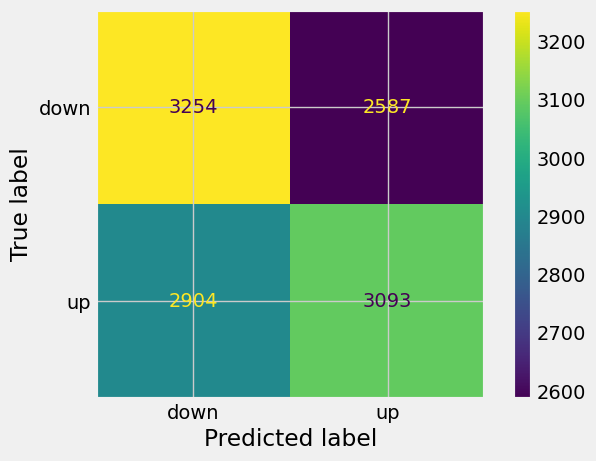

In [181]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = metrics.confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['down', 'up']) # Replace with your class names
disp.plot()


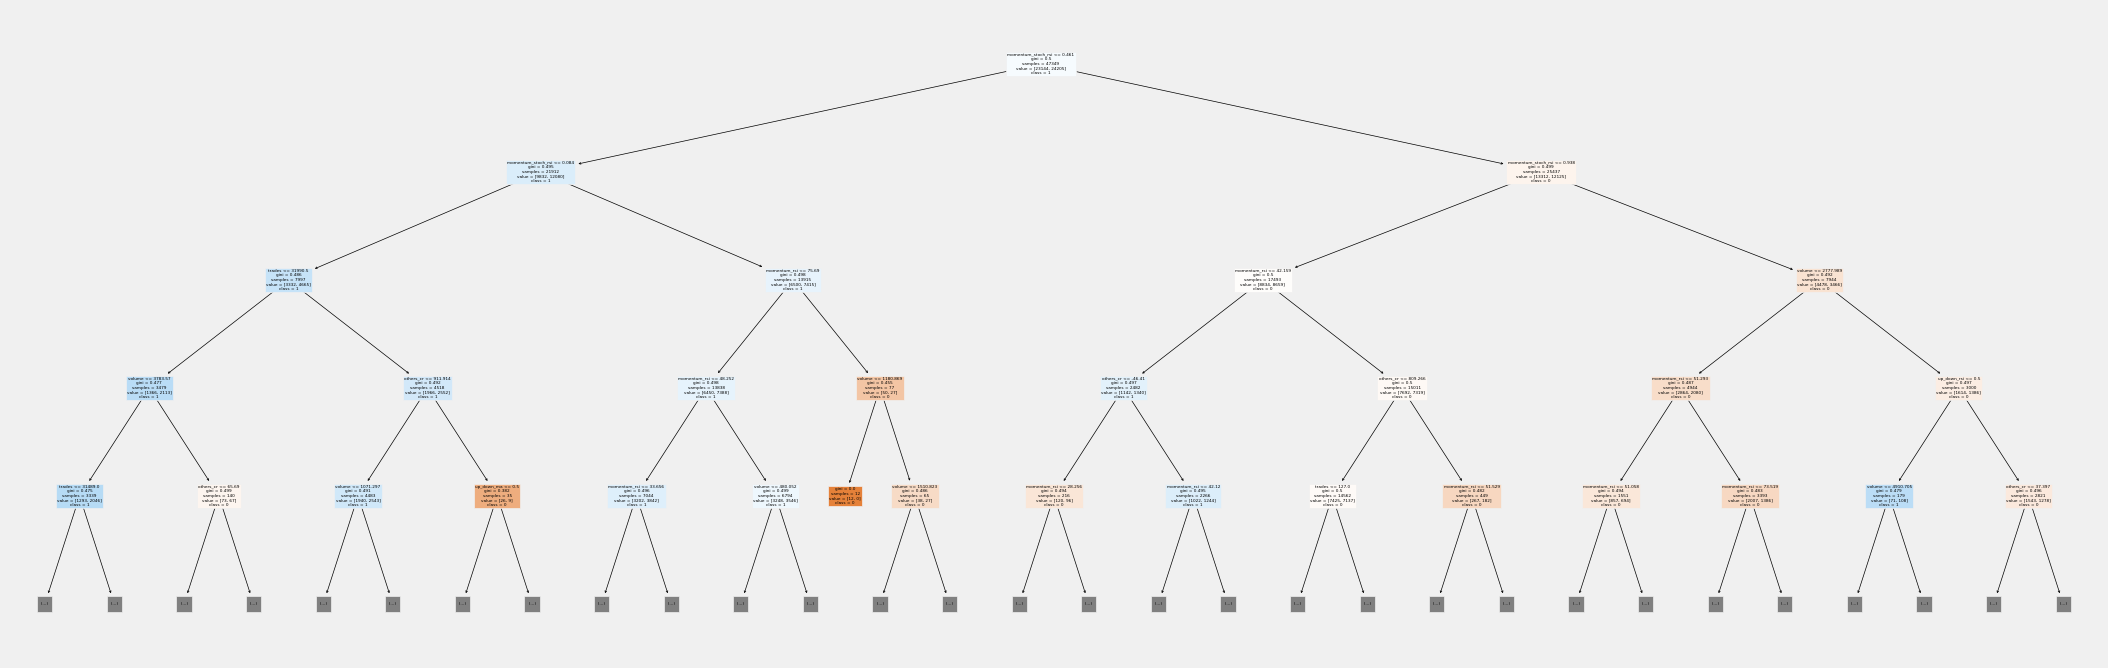

In [182]:
from sklearn.tree import plot_tree

plt.figure(figsize=(24, 8))
plot_tree(tree_model, max_depth=4, filled=True, feature_names=features, class_names=['0','1'])
plt.show()


In [183]:
from sklearn.tree import export_text

tree_rules = export_text(tree_model, feature_names=features)
print(tree_rules)

|--- momentum_stoch_rsi <= 0.46
|   |--- momentum_stoch_rsi <= 0.08
|   |   |--- trades <= 31990.50
|   |   |   |--- volume <= 3783.57
|   |   |   |   |--- trades <= 31489.00
|   |   |   |   |   |--- trades <= 31404.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- trades >  31404.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- trades >  31489.00
|   |   |   |   |   |--- volume <= 434.88
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- volume >  434.88
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- volume >  3783.57
|   |   |   |   |--- others_cr <= 65.69
|   |   |   |   |   |--- trades <= 25903.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- trades >  25903.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- others_cr >  65.69
|   |   |   |   |   |--- momentum_rsi <= 50.31
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- momentum_rsi >  50.31
|   |   |   |   |   |   |--- class: 0
|   |   |---

In [184]:
from sklearn.tree import DecisionTreeClassifier, export_text, _tree

def print_tree_with_counts(clf, feature_names, class_names):
    tree_rules = export_text(clf, feature_names=feature_names)
    print(tree_rules)

    tree_ = clf.tree_
    class_counts = clf.tree_.value.reshape(-1, len(class_names))
    
    for i in range(tree_.node_count):
        if tree_.children_left[i] == _tree.TREE_LEAF:
            print(f"Leaf node {i}:")
            for j, count in enumerate(class_counts[i]):
                print(f"  Class {class_names[j]}: {int(count)} samples")
        else:
            print(f"Node {i}:")
            for j, count in enumerate(class_counts[i]):
                print(f"  Class {class_names[j]}: {int(count)} samples")
            
# Example usage
# Assuming you have already fitted your DecisionTreeClassifier as 'clf'
# and have your feature_names and class_names defined
print_tree_with_counts(tree_model, features, ['0','1'])

|--- momentum_stoch_rsi <= 0.46
|   |--- momentum_stoch_rsi <= 0.08
|   |   |--- trades <= 31990.50
|   |   |   |--- volume <= 3783.57
|   |   |   |   |--- trades <= 31489.00
|   |   |   |   |   |--- trades <= 31404.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- trades >  31404.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- trades >  31489.00
|   |   |   |   |   |--- volume <= 434.88
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- volume >  434.88
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- volume >  3783.57
|   |   |   |   |--- others_cr <= 65.69
|   |   |   |   |   |--- trades <= 25903.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- trades >  25903.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- others_cr >  65.69
|   |   |   |   |   |--- momentum_rsi <= 50.31
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- momentum_rsi >  50.31
|   |   |   |   |   |   |--- class: 0
|   |   |---

In [185]:
df_btc[features+['nextclose','dif_nextclose','var_nextclose','price_increase_quartil']].describe()

trades         volume  momentum_rsi  momentum_stoch_rsi  \
count  5.918700e+04   59187.000000  59187.000000        59187.000000   
mean   6.090436e+04    2984.684771     50.848544            0.508289   
std    9.075615e+04    4242.186162     12.260407            0.348574   
min    3.000000e+00       0.052699      4.365657            0.000000   
25%    1.215900e+04     947.240347     43.090401            0.189400   
50%    3.049500e+04    1649.454890     50.858016            0.511349   
75%    6.672650e+04    3199.202896     58.491740            0.833489   
max    1.442097e+06  137207.188600     96.410500            1.000000   

          others_cr    up_down_ma   up_down_rsi    up_down_ma     nextclose  \
count  59187.000000  59187.000000  59187.000000  59187.000000  59187.000000   
mean     229.261326      0.532887      0.503540      0.532887  23081.823546   
std      257.588079      0.498921      0.499992      0.498921  17887.711925   
min      -66.072361      0.000000      0.000000      0.000000   2919.000000   
25%       13.368479      0.000000      0.000000      0.000000   8155.010000   
50%      161.554939      1.000000      1.000000      1.000000  17157.500000   
75%      387.764072      1.000000      1.000000      1.000000  35960.970000   
max      988.214524      1.000000      1.000000      1.000000  73522.710000   

       dif_nextclose  var_nextclose  price_increase_quartil  
count   59187.000000   59187.000000            59187.000000  
mean        1.091296       0.008224                2.499941  
std       212.398702       0.839586                1.118142  
min     -3789.750000     -18.211473                1.000000  
25%       -40.685000      -0.262078                1.000000  
50%         1.050000       0.009162                2.000000  
75%        44.540000       0.280946                4.000000  
max      3973.890000      17.383989                4.000000

## Prediction updown using slopes updown and fear& greed index

In [186]:
import datetime as dt
import requests
import json

# The API endpoint for the Crypto Fear and Greed Index data
API_URL = "https://api.alternative.me/fng/?limit=0"

# Make a GET request and get the response
response = requests.get(API_URL)

# Check if the request was successful
if response.status_code == 200:
    # Parse the response JSON
    data = json.loads(response.text)
    # Get the list of index values and timestamps
    fng_data = data["data"]
    # Convert the list of dictionaries to a pandas dataframe
    df_fng = pd.DataFrame(fng_data)
    # Rename the columns to more meaningful names
    df_fng = df_fng.rename(columns={"value": "FNG Value", "value_classification": "FNG Classification", "timestamp": "Timestamp"})
    # Convert the timestamp column to a datetime type
    df_fng["Timestamp"] = pd.to_datetime(df_fng["Timestamp"], unit="s")
    # Set the timestamp column as the index
    df_fng = df_fng.set_index("Timestamp")
    # Print the first 5 rows of the dataframe
    print(df_fng.head())
else:
    # Handle the error
    print(f"An error occurred: {response.status_code}")

print(df_fng.columns)
df_fng.reset_index(inplace=True)
print(df_fng.columns)
df_fng.columns = ['open_time','fng', 'fng_classification','time']
print(df_fng.columns)
print(pd.merge(df_btc_day, df_fng[['open_time','fng']], on='open_time', how='inner'))
df_btc_day = pd.merge(df_btc_day, df_fng[['open_time','fng']], on='open_time', how='inner')
# convert fng to int
df_btc_day['fng'] = df_btc_day['fng'].astype(int)
print(df_btc_day.columns)
print(df_btc_day.info())

/tmp/ipykernel_21708/3957983436.py:22: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_fng["Timestamp"] = pd.to_datetime(df_fng["Timestamp"], unit="s")


           FNG Value FNG Classification time_until_update
Timestamp                                                
2024-05-24        74              Greed              3890
2024-05-23        76      Extreme Greed               NaN
2024-05-22        76      Extreme Greed               NaN
2024-05-21        76      Extreme Greed               NaN
2024-05-20        70              Greed               NaN
Index(['FNG Value', 'FNG Classification', 'time_until_update'], dtype='object')
Index(['Timestamp', 'FNG Value', 'FNG Classification', 'time_until_update'], dtype='object')
Index(['open_time', 'fng', 'fng_classification', 'time'], dtype='object')
      open_time      open      high       low     close         volume  \
0    2018-02-01  10285.10  10335.00   8750.99   9224.52   33564.764311   
1    2018-02-02   9224.52   9250.00   8010.02   8873.03   49971.626975   
2    2018-02-03   8873.03   9473.01   8229.00   9199.96   28725.000735   
3    2018-02-04   9199.96   9368.00   7930.00   818

In [205]:
df_btc_day.head()

open_time      open      high      low    close        volume  \
0 2018-02-01  10285.10  10335.00  8750.99  9224.52  33564.764311   
1 2018-02-02   9224.52   9250.00  8010.02  8873.03  49971.626975   
2 2018-02-03   8873.03   9473.01  8229.00  9199.96  28725.000735   
3 2018-02-04   9199.96   9368.00  7930.00  8184.81  32014.308449   
4 2018-02-05   8179.99   8382.80  6625.00  6939.99  63403.182579   

               close_time     quote_vol  trades  taker_buy_base  \
0 2018-02-01 23:59:59.999  3.176363e+08  316020    15430.003849   
1 2018-02-02 23:59:59.999  4.342365e+08  453411    23113.503584   
2 2018-02-03 23:59:59.999  2.568347e+08  327519    14182.838146   
3 2018-02-04 23:59:59.999  2.749123e+08  356134    13805.295790   
4 2018-02-05 23:59:59.999  4.711662e+08  533510    29857.358390   

   taker_buy_quote  ignore   symbol     volume_adi     volume_obv  volume_cmf  \
0     1.461307e+08       0  BTCUSDT  228874.883018  -35730.477933    0.048316   
1     2.012927e+08       0  BTCUSDT  248462.464733  -85702.104908    0.072415   
2     1.270686e+08       0  BTCUSDT  264577.660964  -56977.104173    0.094571   
3     1.188846e+08       0  BTCUSDT  243909.063135  -88991.412622    0.068306   
4     2.220224e+08       0  BTCUSDT  203229.021392 -152394.595201    0.025113   

      volume_fi     volume_em  volume_sma_em    volume_vpt   volume_vwap  \
0 -1.068393e+07 -2.453687e+09  -4.841889e+08  -3377.385999  11048.873031   
1 -1.166687e+07 -2.265452e+09  -6.221083e+08  -5365.247680  10750.121793   
2 -8.658594e+06  9.570757e+08  -1.047120e+09   -845.729818  10506.493846   
3 -1.206441e+07 -9.073543e+08  -9.936927e+08  -2474.167666  10215.292929   
4 -2.161600e+07 -3.174694e+09  -8.999020e+08 -13175.480690   9709.849065   

   volume_mfi   volume_nvi  volatility_bbm  volatility_bbh  volatility_bbl  \
0   38.911057  4288.190542      11471.1585    13828.326704     9113.990296   
1   29.753196  4288.190542      11204.3100    13467.319775     8941.300225   
2   28.116591  4446.190474      10990.5585    13160.982578     8820.134422   
3   29.595093  4446.190474      10722.8025    12890.417202     8555.187798   
4   29.677860  4446.190474      10524.8020    13244.616515     7804.987485   

   volatility_bbw  volatility_bbp  volatility_bbhi  volatility_bbli  \
0       41.097300        0.023445              0.0              0.0   
1       40.395344       -0.015084              0.0              1.0   
2       39.496156        0.087500              0.0              0.0   
3       40.430003       -0.085434              0.0              1.0   
4       51.683908       -0.159018              0.0              1.0   

   volatility_kcc  volatility_kch  volatility_kcl  volatility_kcw  \
0    10884.497667    11978.220667     9790.774667       20.096894   
1    10685.493333    11753.814333     9617.172333       19.995726   
2    10468.210000    11553.884000     9382.536000       20.742305   
3    10186.986000    11332.076000     9041.896000       22.481429   
4     9817.140667    11004.825667     8629.455667       24.196149   

   volatility_kcp  volatility_kchi  volatility_kcli  volatility_dcl  \
0       -0.258866              0.0              1.0         8750.99   
1       -0.348277              0.0              1.0         8010.02   
2       -0.084084              0.0              1.0         8010.02   
3       -0.374244              0.0              1.0         7930.00   
4       -0.711243              0.0              1.0         6625.00   

   volatility_dch  volatility_dcm  volatility_dcw  volatility_dcp  \
0        14580.00       11665.495       50.814484        0.081237   
1        14339.50       11174.760       56.491475        0.136348   
2        14249.99       11130.005       56.775732        0.190696   
3        13542.93       10736.465       52.345737        0.045397   
4        13099.00        9862.000       61.511846        0.048655   

   volatility_atr  volatility_ui   trend_macd  trend_macd_signal  \
0     1410.060965      22.

In [188]:
df_btc_day['up_down'] = df_btc_day['dif_nextclose'].apply(lambda x: 0 if x <= 0 else 1)
df_btc_day['up_down_rsi'] = df_btc_day['slope_rsi'].apply(lambda x: 0 if x <= 0 else 1)
df_btc_day['up_down_obv'] = df_btc_day['slope_obv'].apply(lambda x: 0 if x <= 0 else 1)
df_btc_day['up_down_ma'] = df_btc_day['slope'].apply(lambda x: 0 if x <= 0 else 1)

In [189]:
features + [target]

['trades',
 'volume',
 'momentum_rsi',
 'momentum_stoch_rsi',
 'others_cr',
 'up_down_ma',
 'up_down_rsi',
 'up_down_ma',
 'up_down']

In [190]:
df_btc.columns

Index(['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_vol', 'trades', 'taker_buy_base',
       ...
       'slope_rsi', 'nextclose', 'dif_nextclose', 'var_nextclose',
       'price_increase_quartil', 'up_down', 'up_down_rsi', 'up_down_obv',
       'up_down_ma', 'predictions'],
      dtype='object', length=120)

In [191]:
df_btc[features+[target]].tail()

trades      volume  momentum_rsi  momentum_stoch_rsi  others_cr  \
59208  63541.0  1623.34907     57.052543            1.000000   8.852244   
59209  58338.0  1656.63083     62.292852            1.000000   9.604357   
59210  55386.0  1709.56717     63.503325            1.000000   9.801731   
59211  31132.0   737.61793     64.354298            1.000000   9.932273   
59212  29935.0   671.53851     61.848578            0.891454   9.763523   

       up_down_ma  up_down_rsi  up_down_ma  up_down  
59208           0            1           0        1  
59209           0            1           0        1  
59210           0            1           0        1  
59211           0            1           0        0  
59212           1            1           1        0

In [192]:
# Assuming you have your data in a DataFrame df_btc 
#features = ["trades", "volume", "momentum_rsi", "momentum_stoch_rsi", "morningstar", "hammer", "piercing", "engulfing", "3soldiers", "slope","slope_obv","slope_rsi"]
#features = ["trades", "volume", "slope","slope_obv","slope_rsi"]
features = ["trades", "momentum_rsi", "up_down","up_down_rsi","up_down_ma"] #100% ????? tinha a preditora no teste
features = ["trades", "momentum_rsi", "up_down_ma","up_down_rsi","up_down_ma"] #52%
features = ["trades", "fng", "volume", "momentum_rsi", "momentum_stoch_rsi","up_down_ma","up_down_rsi","up_down_ma"] #56%
target = 'up_down'

X = df_btc_day[features]
y = df_btc_day[target]

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
# 80% of data for training, 20% for testing
# create decision tree regressor object
tree_model = DecisionTreeClassifier(max_depth=6)  # Customize max_depth if needed
tree_model.fit(X_train, y_train)

# Predictions
X_test['predictions'] = tree_model.predict(X_test)
y_pred = X_test['predictions']
df_btc_day['predictions'] = tree_model.predict(df_btc_day[features])

print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.49      0.52       330
           1       0.56      0.61      0.58       352

    accuracy                           0.55       682
   macro avg       0.55      0.55      0.55       682
weighted avg       0.55      0.55      0.55       682

[[163 167]
 [138 214]]
0.5509469696969697


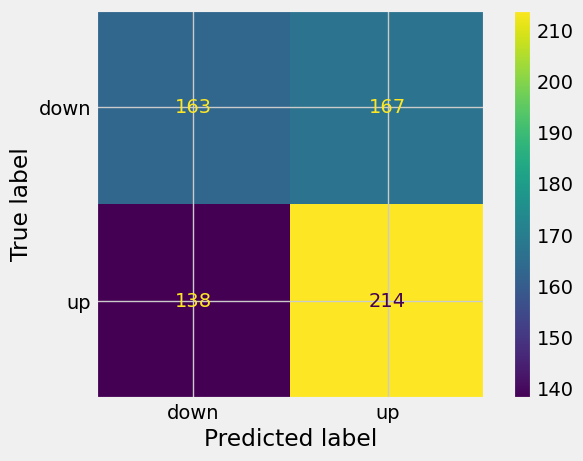

In [193]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = metrics.confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['down', 'up']) # Replace with your class names
disp.plot()


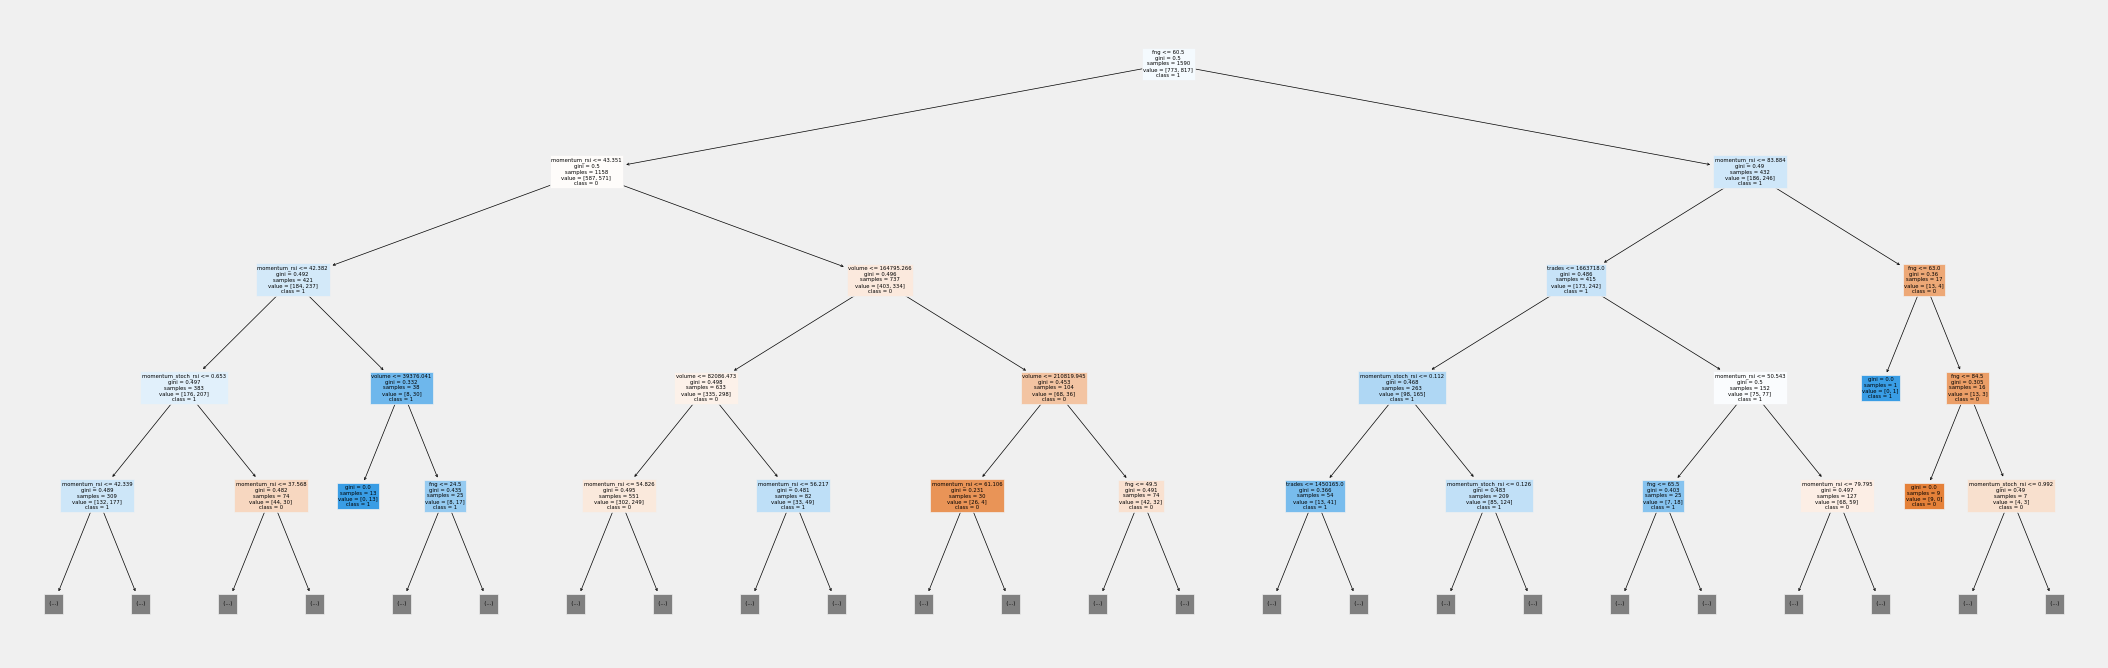

In [194]:
from sklearn.tree import plot_tree

plt.figure(figsize=(24, 8))
plot_tree(tree_model, max_depth=4, filled=True, feature_names=features, class_names=['0','1'])
plt.savefig("decision_tree.pdf", bbox_inches='tight')

plt.show()

In [195]:
from sklearn.tree import export_text

tree_rules = export_text(tree_model, feature_names=features)
print(tree_rules)

|--- fng <= 60.50
|   |--- momentum_rsi <= 43.35
|   |   |--- momentum_rsi <= 42.38
|   |   |   |--- momentum_stoch_rsi <= 0.65
|   |   |   |   |--- momentum_rsi <= 42.34
|   |   |   |   |   |--- volume <= 12988.06
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- volume >  12988.06
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- momentum_rsi >  42.34
|   |   |   |   |   |--- class: 0
|   |   |   |--- momentum_stoch_rsi >  0.65
|   |   |   |   |--- momentum_rsi <= 37.57
|   |   |   |   |   |--- momentum_rsi <= 34.06
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- momentum_rsi >  34.06
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- momentum_rsi >  37.57
|   |   |   |   |   |--- trades <= 1790215.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- trades >  1790215.00
|   |   |   |   |   |   |--- class: 0
|   |   |--- momentum_rsi >  42.38
|   |   |   |--- volume <= 39376.04
|   |   |   |   |--- class: 1
|   |   |   |--- vo

In [196]:
from sklearn.tree import DecisionTreeClassifier, export_text, _tree

def print_tree_with_counts(clf, feature_names, class_names):
    tree_rules = export_text(clf, feature_names=feature_names)
    print(tree_rules)

    tree_ = clf.tree_
    class_counts = clf.tree_.value.reshape(-1, len(class_names))
    
    for i in range(tree_.node_count):
        if tree_.children_left[i] == _tree.TREE_LEAF:
            print(f"Leaf node {i}:")
            for j, count in enumerate(class_counts[i]):
                print(f"  Class {class_names[j]}: {int(count)} samples")
        else:
            print(f"Node {i}:")
            for j, count in enumerate(class_counts[i]):
                print(f"  Class {class_names[j]}: {int(count)} samples")
            
# Example usage
# Assuming you have already fitted your DecisionTreeClassifier as 'clf'
# and have your feature_names and class_names defined
print_tree_with_counts(tree_model, features, ['0','1'])

|--- fng <= 60.50
|   |--- momentum_rsi <= 43.35
|   |   |--- momentum_rsi <= 42.38
|   |   |   |--- momentum_stoch_rsi <= 0.65
|   |   |   |   |--- momentum_rsi <= 42.34
|   |   |   |   |   |--- volume <= 12988.06
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- volume >  12988.06
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- momentum_rsi >  42.34
|   |   |   |   |   |--- class: 0
|   |   |   |--- momentum_stoch_rsi >  0.65
|   |   |   |   |--- momentum_rsi <= 37.57
|   |   |   |   |   |--- momentum_rsi <= 34.06
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- momentum_rsi >  34.06
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- momentum_rsi >  37.57
|   |   |   |   |   |--- trades <= 1790215.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- trades >  1790215.00
|   |   |   |   |   |   |--- class: 0
|   |   |--- momentum_rsi >  42.38
|   |   |   |--- volume <= 39376.04
|   |   |   |   |--- class: 1
|   |   |   |--- vo

In [197]:
df_btc_day[features+['nextclose','dif_nextclose','var_nextclose','price_increase_quartil']].describe()

trades          fng         volume  momentum_rsi  \
count  2.272000e+03  2272.000000    2272.000000   2272.000000   
mean   1.568050e+06    45.680018   76575.168618     52.180973   
std    1.992680e+06    21.890025   84157.307863     13.964244   
min    1.241700e+04     5.000000    1521.537318     10.497797   
25%    3.779348e+05    26.750000   32678.136151     42.693033   
50%    9.243465e+05    44.000000   48248.861180     50.802661   
75%    1.740674e+06    63.000000   79760.693167     61.064542   
max    1.522359e+07    95.000000  760705.362783     89.992159   

       momentum_stoch_rsi   up_down_ma  up_down_rsi   up_down_ma  \
count         2272.000000  2272.000000  2272.000000  2272.000000   
mean             0.505140     0.506162     0.503521     0.506162   
std              0.360685     0.500072     0.500098     0.500072   
min              0.000000     0.000000     0.000000     0.000000   
25%              0.166997     0.000000     0.000000     0.000000   
50%              0.495127     1.000000     1.000000     1.000000   
75%              0.862963     1.000000     1.000000     1.000000   
max              1.000000     1.000000     1.000000     1.000000   

          nextclose  dif_nextclose  var_nextclose  price_increase_quartil  
count   2272.000000    2272.000000    2272.000000             2272.000000  
mean   23884.028838      23.799023       0.151882                2.496919  
std    17871.098655    1039.970693       3.612711                1.124950  
min     3211.720000   -7038.700000     -39.504847                1.000000  
25%     8526.137500    -234.105000      -1.405261                1.000000  
50%    19344.560000       8.355000       0.084517                2.000000  
75%    37316.702500     274.512500       1.672869                4.000000  
max    73072.410000    7579.180000      19.536139                4.000000

## Prediction xgboost updown using slopes updown and fear& greed index

In [198]:
df_btc_day.head()

open_time      open      high      low    close        volume  \
0 2018-02-01  10285.10  10335.00  8750.99  9224.52  33564.764311   
1 2018-02-02   9224.52   9250.00  8010.02  8873.03  49971.626975   
2 2018-02-03   8873.03   9473.01  8229.00  9199.96  28725.000735   
3 2018-02-04   9199.96   9368.00  7930.00  8184.81  32014.308449   
4 2018-02-05   8179.99   8382.80  6625.00  6939.99  63403.182579   

               close_time     quote_vol  trades  taker_buy_base  \
0 2018-02-01 23:59:59.999  3.176363e+08  316020    15430.003849   
1 2018-02-02 23:59:59.999  4.342365e+08  453411    23113.503584   
2 2018-02-03 23:59:59.999  2.568347e+08  327519    14182.838146   
3 2018-02-04 23:59:59.999  2.749123e+08  356134    13805.295790   
4 2018-02-05 23:59:59.999  4.711662e+08  533510    29857.358390   

   taker_buy_quote  ignore   symbol     volume_adi     volume_obv  volume_cmf  \
0     1.461307e+08       0  BTCUSDT  228874.883018  -35730.477933    0.048316   
1     2.012927e+08       0  BTCUSDT  248462.464733  -85702.104908    0.072415   
2     1.270686e+08       0  BTCUSDT  264577.660964  -56977.104173    0.094571   
3     1.188846e+08       0  BTCUSDT  243909.063135  -88991.412622    0.068306   
4     2.220224e+08       0  BTCUSDT  203229.021392 -152394.595201    0.025113   

      volume_fi     volume_em  volume_sma_em    volume_vpt   volume_vwap  \
0 -1.068393e+07 -2.453687e+09  -4.841889e+08  -3377.385999  11048.873031   
1 -1.166687e+07 -2.265452e+09  -6.221083e+08  -5365.247680  10750.121793   
2 -8.658594e+06  9.570757e+08  -1.047120e+09   -845.729818  10506.493846   
3 -1.206441e+07 -9.073543e+08  -9.936927e+08  -2474.167666  10215.292929   
4 -2.161600e+07 -3.174694e+09  -8.999020e+08 -13175.480690   9709.849065   

   volume_mfi   volume_nvi  volatility_bbm  volatility_bbh  volatility_bbl  \
0   38.911057  4288.190542      11471.1585    13828.326704     9113.990296   
1   29.753196  4288.190542      11204.3100    13467.319775     8941.300225   
2   28.116591  4446.190474      10990.5585    13160.982578     8820.134422   
3   29.595093  4446.190474      10722.8025    12890.417202     8555.187798   
4   29.677860  4446.190474      10524.8020    13244.616515     7804.987485   

   volatility_bbw  volatility_bbp  volatility_bbhi  volatility_bbli  \
0       41.097300        0.023445              0.0              0.0   
1       40.395344       -0.015084              0.0              1.0   
2       39.496156        0.087500              0.0              0.0   
3       40.430003       -0.085434              0.0              1.0   
4       51.683908       -0.159018              0.0              1.0   

   volatility_kcc  volatility_kch  volatility_kcl  volatility_kcw  \
0    10884.497667    11978.220667     9790.774667       20.096894   
1    10685.493333    11753.814333     9617.172333       19.995726   
2    10468.210000    11553.884000     9382.536000       20.742305   
3    10186.986000    11332.076000     9041.896000       22.481429   
4     9817.140667    11004.825667     8629.455667       24.196149   

   volatility_kcp  volatility_kchi  volatility_kcli  volatility_dcl  \
0       -0.258866              0.0              1.0         8750.99   
1       -0.348277              0.0              1.0         8010.02   
2       -0.084084              0.0              1.0         8010.02   
3       -0.374244              0.0              1.0         7930.00   
4       -0.711243              0.0              1.0         6625.00   

   volatility_dch  volatility_dcm  volatility_dcw  volatility_dcp  \
0        14580.00       11665.495       50.814484        0.081237   
1        14339.50       11174.760       56.491475        0.136348   
2        14249.99       11130.005       56.775732        0.190696   
3        13542.93       10736.465       52.345737        0.045397   
4        13099.00        9862.000       61.511846        0.048655   

   volatility_atr  volatility_ui   trend_macd  trend_macd_signal  \
0     1410.060965      22.

In [199]:
df_btc_day['up_down'] = df_btc_day['dif_nextclose'].apply(lambda x: 0 if x <= 0 else 1)
df_btc_day['up_down_rsi'] = df_btc_day['slope_rsi'].apply(lambda x: 0 if x <= 0 else 1)
df_btc_day['up_down_obv'] = df_btc_day['slope_obv'].apply(lambda x: 0 if x <= 0 else 1)
df_btc_day['up_down_ma'] = df_btc_day['slope'].apply(lambda x: 0 if x <= 0 else 1)

In [200]:
features + [target]

['trades',
 'fng',
 'volume',
 'momentum_rsi',
 'momentum_stoch_rsi',
 'up_down_ma',
 'up_down_rsi',
 'up_down_ma',
 'up_down']

In [201]:
df_btc_day.columns

Index(['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_vol', 'trades', 'taker_buy_base',
       ...
       'nextclose', 'dif_nextclose', 'var_nextclose', 'price_increase_quartil',
       'fng', 'up_down', 'up_down_rsi', 'up_down_obv', 'up_down_ma',
       'predictions'],
      dtype='object', length=118)

In [202]:
df_btc_day[features+[target]].tail()

trades  fng       volume  momentum_rsi  momentum_stoch_rsi  up_down_ma  \
2267   992921   69  18526.75029     50.063764            0.902870           0   
2268  1392557   71  34674.91949     47.852279            0.827312           0   
2269  1272898   68  25598.79472     45.663829            0.733986           0   
2270  1415152   64  26121.19004     42.892762            0.566452           0   
2271  1381957   55  30660.80610     48.545015            0.908179           0   

      up_down_rsi  up_down_ma  up_down  
2267            1           0        0  
2268            1           0        0  
2269            1           0        0  
2270            1           0        1  
2271            1           0        0

In [203]:
df_btc_day.dtypes

open_time                    datetime64[ns]
open                                float64
high                                float64
low                                 float64
close                               float64
volume                              float64
close_time                   datetime64[ns]
quote_vol                           float64
trades                                int64
taker_buy_base                      float64
taker_buy_quote                     float64
ignore                                int64
symbol                               object
volume_adi                          float64
volume_obv                          float64
volume_cmf                          float64
volume_fi                           float64
volume_em                           float64
volume_sma_em                       float64
volume_vpt                          float64
volume_vwap                         float64
volume_mfi                          float64
volume_nvi                      

In [210]:
from xgboost import XGBClassifier 
import xgboost as xgb
# Assuming you have your data in a DataFrame df_btc 
#features = ["trades", "volume", "momentum_rsi", "momentum_stoch_rsi", "morningstar", "hammer", "piercing", "engulfing", "3soldiers", "slope","slope_obv","slope_rsi"]
#features = ["trades", "volume", "slope","slope_obv","slope_rsi"]
#features = ["trades", "momentum_rsi", "up_down","up_down_rsi","up_down_ma"] #100% ????? tinha a preditora no teste
#features = ["trades", "momentum_rsi", "up_down_ma","up_down_rsi","up_down_ma"] #52%
features = ["trades", "fng", "volume", "momentum_rsi", "momentum_stoch_rsi","up_down_ma","up_down_rsi","up_down_obv"] #56%
#features = ["open","high","low","close","trades", "fng", "volume", "momentum_rsi", "momentum_stoch_rsi","up_down_ma","up_down_rsi","up_down_obv"] #56%

target = 'up_down'

X = df_btc_day[features]
y = df_btc_day[target]

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
# 80% of data for training, 20% for testing
# create decision tree regressor object
params = {
    'objective': 'binary:logistic',  # Use logistic regression for binary classification
    'eval_metric': ['logloss', 'auc'],  # Use multiple evaluation metrics
    'max_depth': 10,
    'eta': 0.1
}
model_xgb = XGBClassifier()  # Customize max_depth if needed
model_xgb.fit(X_train, y_train)

# Predictions
X_test['predictions'] = model_xgb.predict(X_test)
y_pred = X_test['predictions']
df_btc_day['predictions'] = model_xgb.predict(df_btc_day[features])

print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.54      0.54       330
           1       0.57      0.57      0.57       352

    accuracy                           0.55       682
   macro avg       0.55      0.55      0.55       682
weighted avg       0.55      0.55      0.55       682

[[177 153]
 [153 199]]
0.5508522727272728


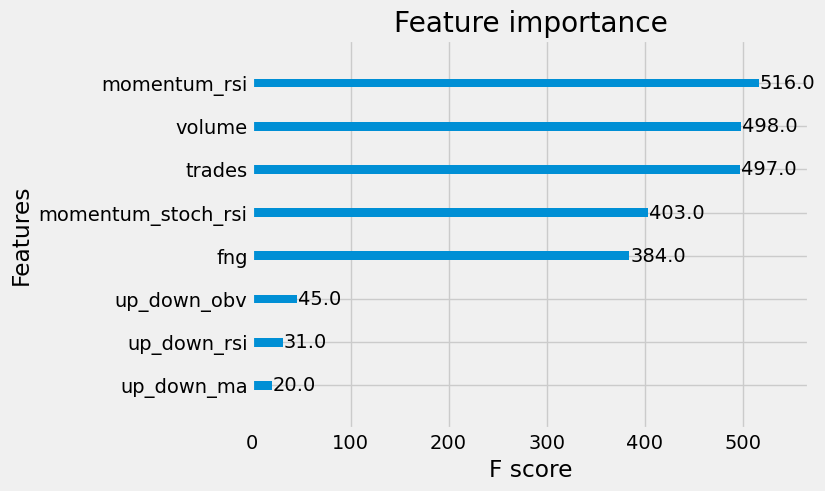

In [211]:
xgb.plot_importance(model_xgb)  # Plot feature importance
plt.show()


Recall = (True Positives) / (True Positives + False Negatives)

True Positives (TP): The number of positive instances correctly predicted as positive.
False Negatives (FN): The number of positive instances incorrectly predicted as negative.
Interpretation:

A recall of 1.0 (or 100%) means the model perfectly identifies all positive instances.
A recall of 0.0 (or 0%) means the model fails to identify any positive instances.
Significance:

Recall is crucial in situations where it's essential to capture as many positive instances as possible, even at the cost of some false positives.  Examples include:
* Medical Diagnosis: Identifying all patients with a disease, even if some healthy individuals are incorrectly flagged, is better than missing true cases.
* Fraud Detection: Catching all fraudulent transactions, even if some legitimate ones are mistakenly flagged, is more important than missing fraudulent activity.

In our case we want to predict the up and down of the stock price. We want to capture as many up movements as possible, even if some down movements are incorrectly flagged. Therefore, we will use the recall as the main metric to evaluate the model.

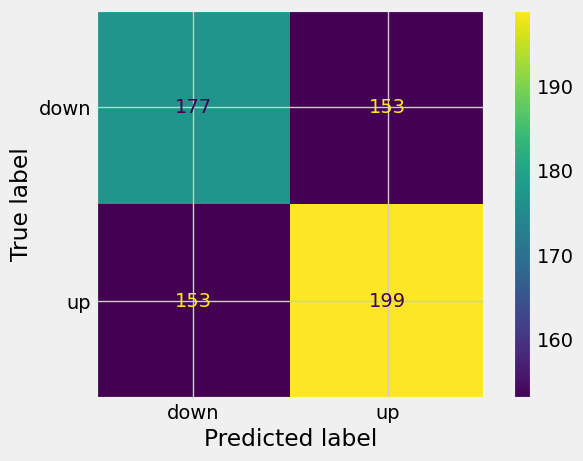

In [212]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = metrics.confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['down', 'up']) # Replace with your class names
disp.plot()


In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(24, 8))
plot_tree(tree_model, max_depth=4, filled=True, feature_names=features, class_names=['0','1'])
plt.savefig("decision_tree.pdf", bbox_inches='tight')

plt.show()

In [ ]:
from sklearn.tree import export_text

tree_rules = export_text(tree_model, feature_names=features)
print(tree_rules)

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_text, _tree

def print_tree_with_counts(clf, feature_names, class_names):
    tree_rules = export_text(clf, feature_names=feature_names)
    print(tree_rules)

    tree_ = clf.tree_
    class_counts = clf.tree_.value.reshape(-1, len(class_names))
    
    for i in range(tree_.node_count):
        if tree_.children_left[i] == _tree.TREE_LEAF:
            print(f"Leaf node {i}:")
            for j, count in enumerate(class_counts[i]):
                print(f"  Class {class_names[j]}: {int(count)} samples")
        else:
            print(f"Node {i}:")
            for j, count in enumerate(class_counts[i]):
                print(f"  Class {class_names[j]}: {int(count)} samples")
            
# Example usage
# Assuming you have already fitted your DecisionTreeClassifier as 'clf'
# and have your feature_names and class_names defined
print_tree_with_counts(tree_model, features, ['0','1'])

In [ ]:
df_btc_day[features+['nextclose','dif_nextclose','var_nextclose','price_increase_quartil']].describe()